In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
def clean_direc(direc):
    if pd.isna(direc):
        return np.nan

    if len(direc) == 3:
        direc = direc.strip()[-2:].upper()
    else:
        direc = direc.strip().upper()

    return direc

df = pd.read_csv('data/sonoma_data_clean.csv', parse_dates=['epoch_datetime'])
df.drop(['hamatop','hamabot'], axis=1, inplace=True)
df['direc'] = df.direc.apply(clean_direc)
df['is_interior'] = (df.tree == 'interior').astype(int)
df['hour'] = df.epoch_datetime.dt.hour

## Data Yield

<AxesSubplot:>

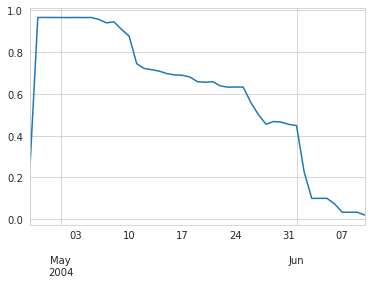

In [3]:
(df.epoch_datetime.dt.to_period('D').value_counts().sort_index() / (24*60/5*30)).plot()

<AxesSubplot:>

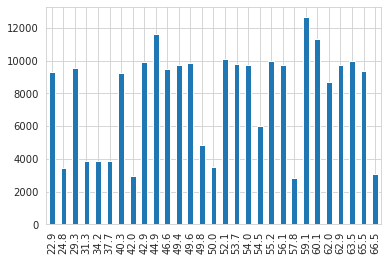

In [43]:
df.height.value_counts().sort_index().plot(kind='bar')

## EDA Exploration

In [44]:
sub = df.groupby([df.epoch_datetime.dt.hour, df.nodeid]).aggregate({
    'height': 'mean',
    'direc': 'last',
    'dist': 'last',
    'humidity': 'mean',
    'humid_temp': 'mean',
    'incident_par': 'mean',
    'reflected_par':'mean',
}).reset_index()
sub = sub[sub.nodeid!=135]

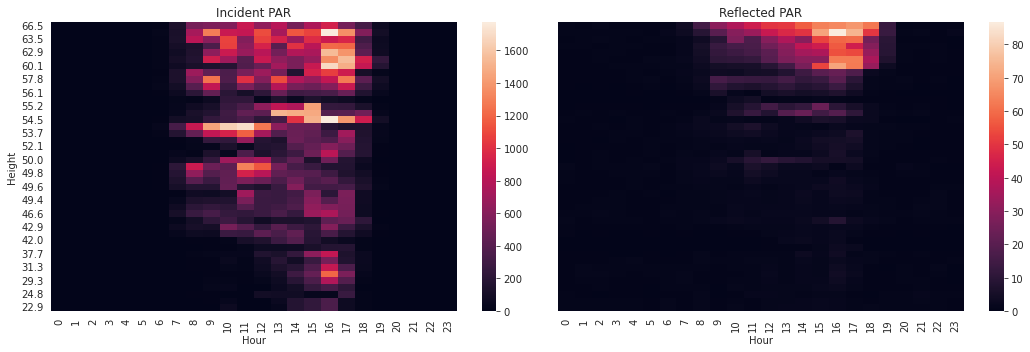

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

to_plot = (
    sub[['epoch_datetime','height','incident_par']]
    .set_index(['epoch_datetime','height'])
    .unstack().T
    .sort_index(ascending=False)
    .interpolate(method='linear')
)
to_plot.index = np.round(to_plot.index.droplevel(0), 1)
sns.heatmap(to_plot, ax=ax[0])
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Height')
ax[0].set_title('Incident PAR')

to_plot = (
    sub[['epoch_datetime','height','reflected_par']]
    .set_index(['epoch_datetime','height'])
    .unstack().T
    .sort_index(ascending=False)
    .interpolate(method='linear')
)
to_plot.index = np.round(to_plot.index.droplevel(0), 1)
sns.heatmap(to_plot, ax=ax[1])
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('')
ax[1].set_title('Reflected PAR')

fig.tight_layout()
fig.show()

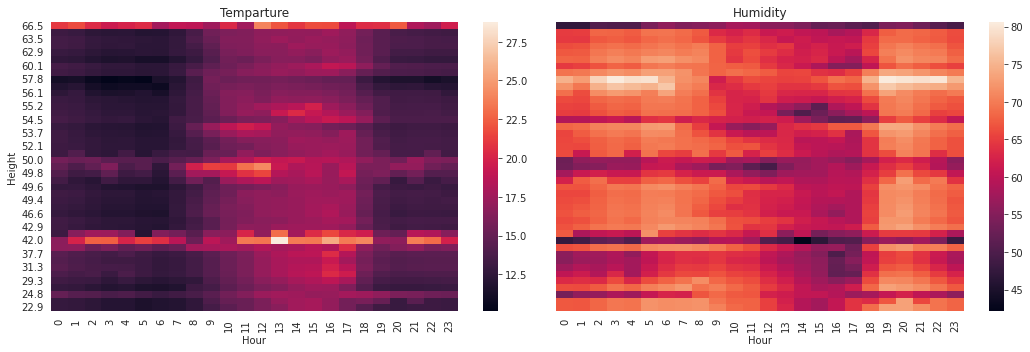

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

to_plot = (
    sub[['epoch_datetime','height','humid_temp']]
    .set_index(['epoch_datetime','height'])
    .unstack().T
    .sort_index(ascending=False)
    .interpolate(method='linear')
)
to_plot.index = np.round(to_plot.index.droplevel(0), 1)
sns.heatmap(to_plot, ax=ax[0])
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Height')
ax[0].set_title('Temparture')

to_plot = (
    sub[['epoch_datetime','height','humidity']]
    .set_index(['epoch_datetime','height'])
    .unstack().T
    .sort_index(ascending=False)
    .interpolate(method='linear')
)
to_plot.index = np.round(to_plot.index.droplevel(0), 1)
sns.heatmap(to_plot, ax=ax[1])
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('')
ax[1].set_title('Humidity')

fig.tight_layout()
fig.show()

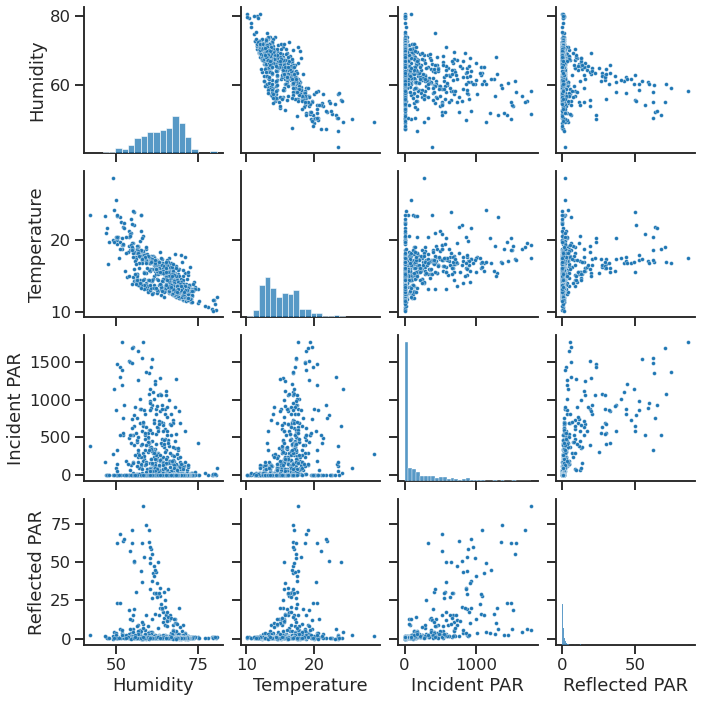

In [170]:
to_plot = (
    sub.drop(['nodeid','dist','height','epoch_datetime'], axis=1)
    .rename({'humidity': 'Humidity', 'humid_temp': 'Temperature', 'incident_par': 'Incident PAR', 'reflected_par': 'Reflected PAR'}, axis=1)
)
with sns.axes_style('ticks'):
    sns.pairplot(to_plot, height=2.5, corner=False, plot_kws={'s': 15})

## PAR Prediction

In [105]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

subset = df[(df.nodeid!=135)]
X = subset[['hour','height','dist','direc','is_interior']]
X = sm.add_constant(pd.get_dummies(X, columns=['hour', 'direc']))
y = subset['incident_par'] + 1

# model = sm.OLS(y, X)
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.genmod.families.links.Log()))
res = model.fit()

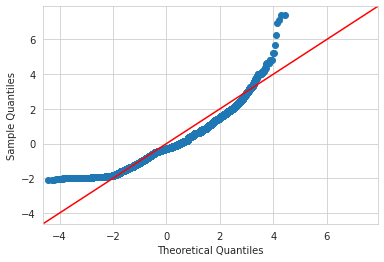

In [106]:
_ = sm.graphics.qqplot(res.resid_anscombe, line='45')

<AxesSubplot:xlabel='incident_par', ylabel='Density'>

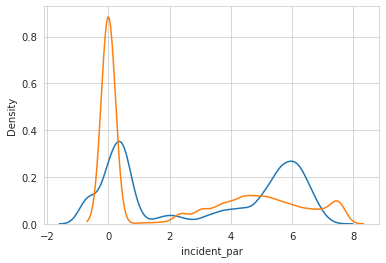

In [149]:
sns.kdeplot(X@res.params)
sns.kdeplot(np.log(y))

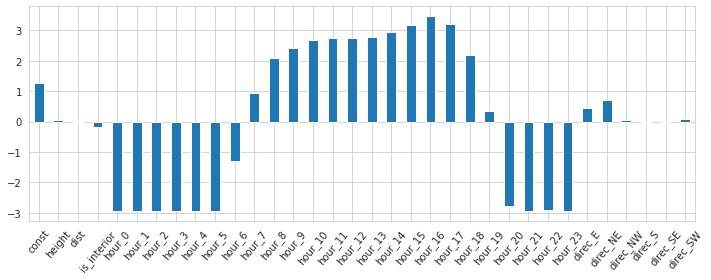

In [123]:
fig, ax = plt.subplots(figsize=(10, 4))

res.params.plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

fig.tight_layout()
fig.show()

In [114]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           incident_par   No. Observations:               228103
Model:                            GLM   Df Residuals:                   228071
Model Family:                   Gamma   Df Model:                           31
Link Function:                    Log   Scale:                          1.6335
Method:                          IRLS   Log-Likelihood:            -9.4294e+05
Date:                Sun, 09 Oct 2022   Deviance:                   2.9603e+05
Time:                        09:43:14   Pearson chi2:                 3.73e+05
No. Iterations:                    46   Pseudo R-squ. (CS):             0.9351
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2703      0.020     62.357      0.000       1.230       1.310
height          0.0369      0.000    134.136      0.000       0.036       0.037
dist            0.0168      0.004      4.646      0.000       0.010       0.024
is_interior    -0.1902      0.028     -6.697      0.000      -0.246      -0.135
hour_0         -2.9393      0.013   -229.891      0.000      -2.964      -2.914
hour_1         -2.9429      0.013   -229.288      0.000      -2.968      -2.918
hour_2         -2.9423      0.013   -229.637      0.000      -2.967      -2.917
hour_3         -2.9407      0.013   -229.984      0.000      -2.966      -2.916
hour_4         -2.9464      0.013   -229.738      0.000      -2.972      -2.921
hour_5         -2.9431      0.013   -229.627      0.000      -2.968      -2.918
hour_6         -1.2825      0.013    -99.822      0.000      -1.308      -1.257
hour_7          0.9331      0.013     72.423      0.000       0.908       0.958
hour_8          2.0901      0.013    162.155      0.000       2.065       2.115
hour_9          2.4286      0.013    188.841      0.000       2.403       2.454
hour_10         2.6708      0.013    206.966      0.000       2.646       2.696
hour_11         2.7373      0.013    211.321      0.000       2.712       2.763
hour_12         2.7493      0.013    212.340      0.000       2.724       2.775
hour_13         2.7887      0.013    215.682      0.000       2.763       2.814
hour_14         2.9591      0.013    227.715      0.000       2.934       2.985
hour_15         3.1962      0.013    245.600      0.000       3.171       3.222
hour_16         3.4715      0.013    266.442      0.000       3.446       3.497
hour_17         3.2146      0.013    250.444      0.000       3.189       3.240
hour_18         2.1763      0.013    170.090      0.000       2.151       2.201
hour_19         0.3643      0.013     28.540      0.000       0.339       0.389
hour_20        -2.7871      0.013   -217.968      0.000      -2.812      -2.762
hour_21        -2.9296      0.013   -228.282      0.000      -2.955      -2.904
hour_22        -2.9216      0.013   -228.730      0.000      -2.947      -2.897
hour_23        -2.9341      0.013   -229.197      0.000      -2.959      -2.909
direc_E         0.4501      0.018     25.302      0.000       0.415       0.485
direc_NE        0.6958      0.013     53.147      0.000       0.670       0.721
direc_NW        0.0479      0.010      4.753      0.000       0.028       0.068
direc_S        -0.0592      0.013     -4.598      0.000      -0.084      -0.034
direc_SE        0.0348      0.019      1.814      0.070      -0.003       0.072
direc_SW        0.1008      0.010     10.580      0.000       0.082       0.120
===============================================================================
"""

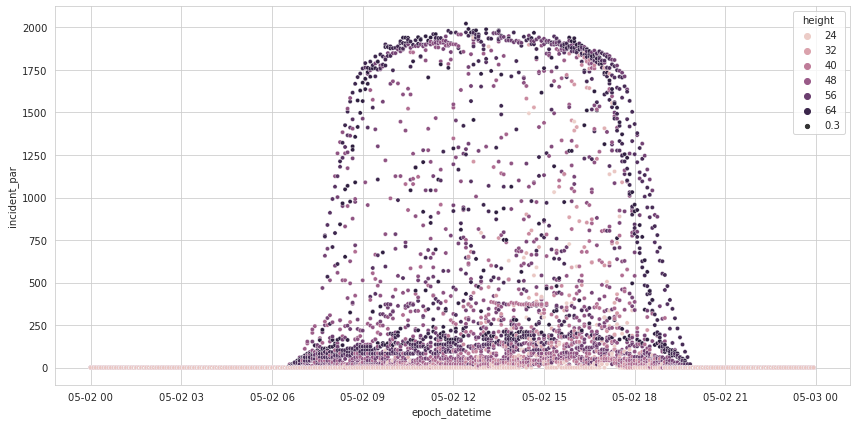

In [117]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=sub, y='incident_par', x=sub.epoch_datetime, size=0.3, ax=ax, hue='height')
fig.tight_layout()
fig.show()

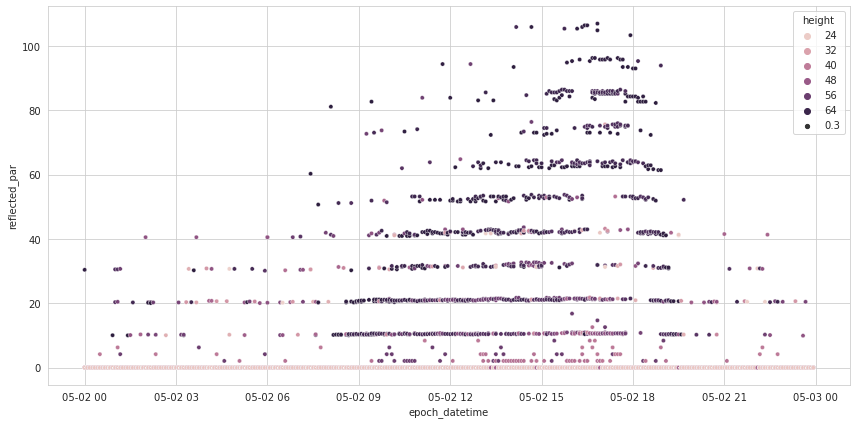

In [104]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=sub, y='reflected_par', x=sub.epoch_datetime, size=0.3, ax=ax, hue='height')
fig.tight_layout()
fig.show()

## Time Series Analysis

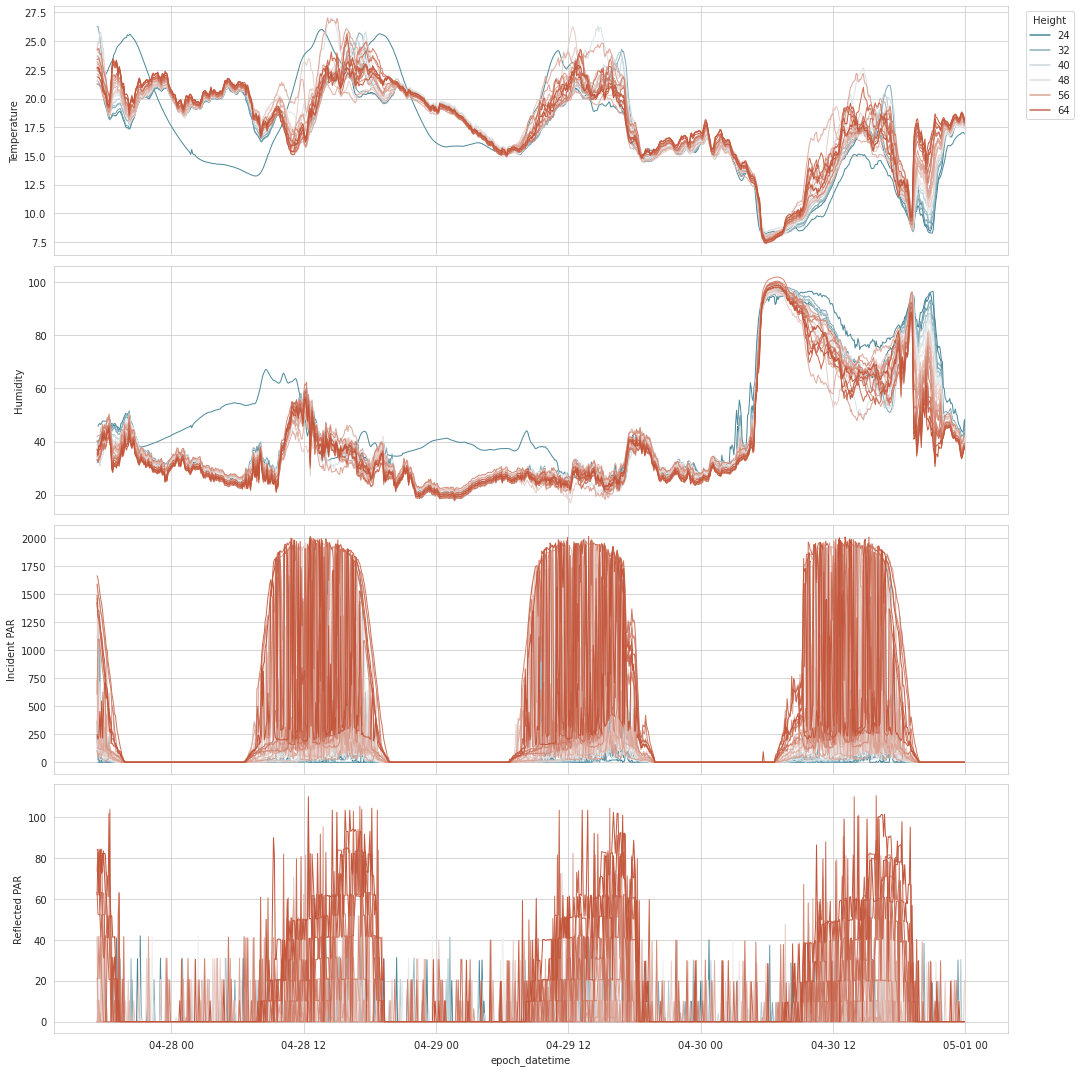

In [91]:
to_plot = df[df.epoch_datetime.between('2004-04-27','2004-05-01', inclusive="left")]
fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

sns.lineplot(data=to_plot, x='epoch_datetime', y='humid_temp', hue='height', ax=ax[0], linewidth=1, palette=sns.diverging_palette(220, 20, as_cmap=True))
sns.lineplot(data=to_plot, x='epoch_datetime', y='humidity', hue='height', ax=ax[1], linewidth=1, palette=sns.diverging_palette(220, 20, as_cmap=True))
sns.lineplot(data=to_plot, x='epoch_datetime', y='incident_par', hue='height', ax=ax[2], linewidth=1, palette=sns.diverging_palette(220, 20, as_cmap=True))
sns.lineplot(data=to_plot, x='epoch_datetime', y='reflected_par', hue='height', ax=ax[3], linewidth=1, palette=sns.diverging_palette(220, 20, as_cmap=True))

ax[0].get_legend().remove()
ax[0].set_ylabel('Temperature')
ax[0].legend(bbox_to_anchor=(1.075, 1), title='Height')
ax[1].get_legend().remove()
ax[1].set_ylabel('Humidity')
ax[2].get_legend().remove()
ax[2].set_ylabel('Incident PAR')
ax[3].get_legend().remove()
ax[3].set_ylabel('Reflected PAR')

fig.tight_layout()
fig.show()

In [52]:
df[df.nodeid==78].groupby('source').voltage.describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
log,2832.0,2.705006,0.114604,2.39484,2.60491,2.7244,2.80151,2.89717
net,238.0,260.113445,8.024734,242.00000,256.00000,260.0000,266.00000,284.00000


In [46]:
df[df.humid_temp > 40].head(100)

,epoch_datetime,nodeid,result_time,epoch,parent,voltage,depth,humidity,humid_temp,source,height,direc,dist,tree,is_log,incident_par,reflected_par,is_interior,hour
91521,2004-05-08 17:40:00,78,2004-05-09 00:40:02.492946,3175,118,259.0,2,68.2414,41.0878,net,66.5,SW,0.1,interior,False,771.342593,66.352037,1,17
91952,2004-05-08 18:55:00,78,2004-05-09 01:55:02.272582,3190,118,262.0,2,80.6215,61.1288,net,66.5,SW,0.1,interior,False,147.582778,57.393333,1,18
92010,2004-05-08 19:05:00,78,2004-05-09 02:05:02.572992,3192,118,261.0,2,93.3608,50.3782,net,66.5,SW,0.1,interior,False,131.687222,32.921852,1,19
92182,2004-05-08 19:35:00,78,2004-05-09 02:35:03.292152,3198,118,264.0,2,101.7600,99.0254,net,66.5,SW,0.1,interior,False,56.958519,0.000000,1,19
92210,2004-05-08 19:40:00,78,2004-05-09 02:40:03.310967,3199,118,264.0,2,89.3425,118.6650,net,66.5,SW,0.1,interior,False,48.821481,0.000000,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98722,2004-05-09 15:10:00,78,2004-05-09 22:10:08.167727,3433,77,266.0,3,66.2973,122.1530,net,66.5,SW,0.1,interior,False,242.272222,80.757407,1,15
98833,2004-05-09 15:30:00,78,2004-05-09 22:30:08.914143,3437,77,266.0,3,84.6076,122.1530,net,66.5,SW,0.1,interior,False,839.877778,64.605926,1,15
99063,2004-05-09 16:10:00,145,2004-05-09 23:10:10.117851,3445,4,1023.0,3,64.1208,42.7734,net,42.0,SW,3.0,interior,False,18.898704,8.399407,1,16
99078,2004-05-09 16:15:00,78,2004-05-09 23:15:08.22185,3446,77,267.0,3,100.6640,122.1530,net,66.5,SW,0.1,interior,False,225.274074,88.500556,1,16


## PCA

In [7]:
subset = df[(df.nodeid!=135)]
X = subset[['nodeid','hour','height','dist','direc','is_interior','humidity','humid_temp','incident_par','reflected_par']]

node_meta = subset[['nodeid','height','dist','direc','is_interior']].drop_duplicates().set_index('nodeid')

X = X.groupby(['nodeid','hour']).aggregate({
    'humidity': 'mean',
    'humid_temp': 'mean',
    'incident_par': 'mean',
    'reflected_par':'mean',
})
stage = X.stack().reset_index()
stage['feature'] = stage.apply(lambda x: f"{x['level_2']}_{x['hour']}", axis=1)
stage.drop(['level_2','hour'], axis=1, inplace=True)
X = (
    stage
    .set_index(['nodeid','feature'])
    .unstack()
    .droplevel(0, axis=1)
    .join(node_meta)
)
X = pd.get_dummies(X, columns=['direc'])

In [98]:
standardlize_map = {}
ignore_cols = ['interior', 'direc']
for col in X.columns:
    ignore = False
    for icol in ignore_cols:
        if icol in col:
            ignore = True
            break
    
    if ignore: continue
    
    mu = X[col].mean()
    std = X[col].std()
    X.loc[:, col] = (X[col] - mu) / std
    standardlize_map[col] = (mu, std)

In [119]:
from sklearn.decomposition import PCA
import statsmodels.api as sm

In [120]:
pca = sm.multivariate.PCA(X, standardize=False, demean=False, normalize=False)

<AxesSubplot:>

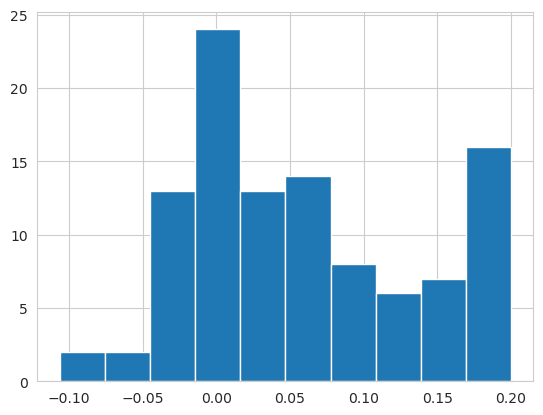

In [134]:
pca.loadings.iloc[:,1].hist()

<AxesSubplot:>

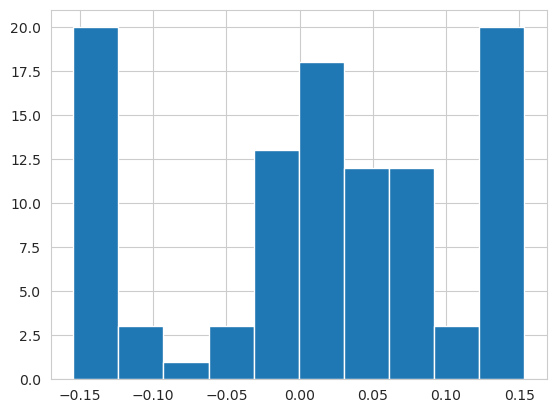

In [135]:
pca.loadings.iloc[:,0].hist()

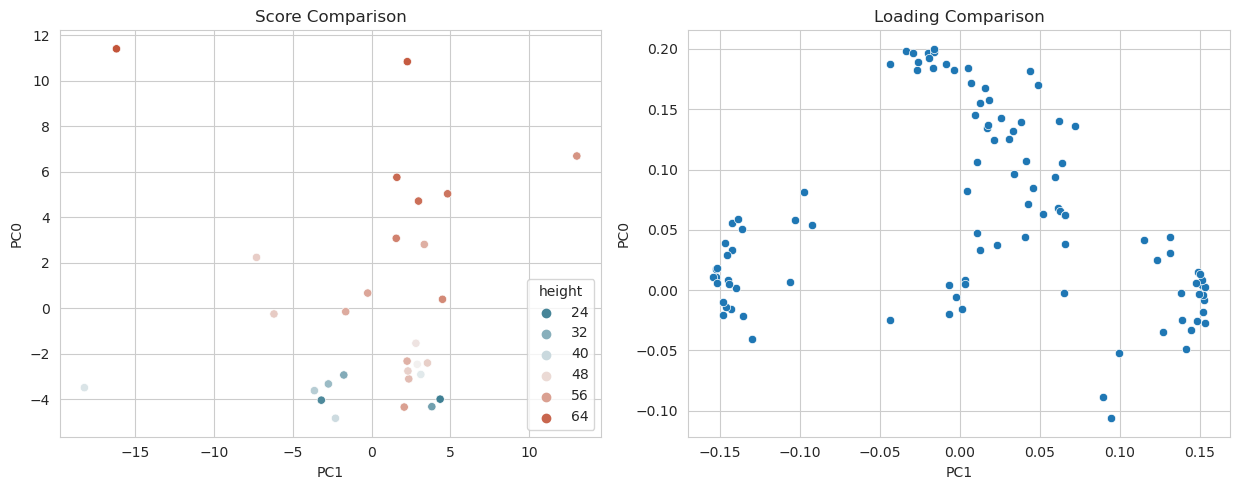

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))

sns.scatterplot(data=pca.loadings[['comp_00','comp_01']], x='comp_00', y='comp_01', ax=ax[1])
sns.scatterplot(data=pca.factors, x='comp_00', y='comp_01', hue=node_meta.height, palette=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[0])

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC0')
ax[0].set_title('Score Comparison')

ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC0')
ax[1].set_title('Loading Comparison')
fig.tight_layout()
fig.show()

## GMM Clustering

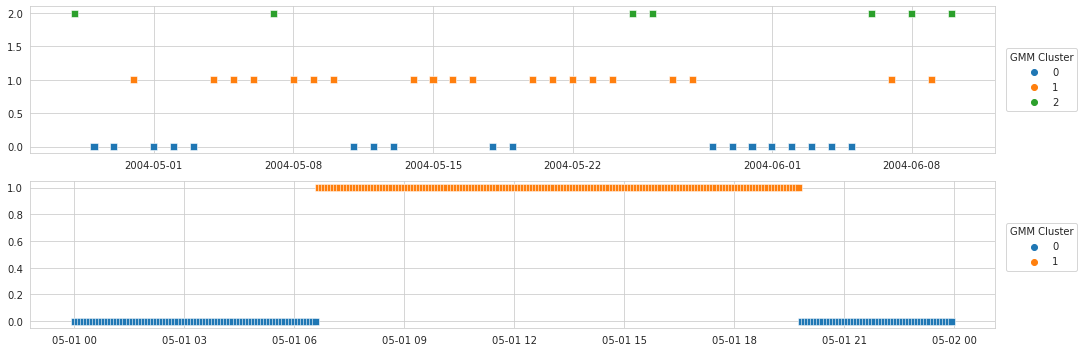

In [92]:
from sklearn.mixture import GaussianMixture

np.random.seed(352)
fig, ax = plt.subplots(2, 1, figsize=(15, 5))

gp = df.groupby([df.epoch_datetime.dt.to_period('D')])
X = gp[['humidity','humid_temp','incident_par','reflected_par']].mean().join(
    gp[['humidity','humid_temp','incident_par','reflected_par']].std(),
    lsuffix='_mean', rsuffix='_std'
)
X = ((X - X.mean()) / X.std())

gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(X)

to_plot = pd.DataFrame({
    'day': X.index.to_timestamp(),
    'label': gmm.predict(X)
})
sns.scatterplot(data=to_plot, x='day', y='label', hue='label', s=50, marker='s', ax=ax[0], palette=sns.color_palette("tab10", n_colors=3))
ax[0].legend(title='GMM Cluster', bbox_to_anchor=(1.09, 0.75))
ax[0].set_xlabel('')
ax[0].set_ylabel('')


gp = df.groupby([df.epoch_datetime.dt.to_period('10T')])
X = gp[['humidity','humid_temp','incident_par','reflected_par']].mean().join(
    gp[['humidity','humid_temp','incident_par','reflected_par']].std(),
    lsuffix='_mean', rsuffix='_std'
).loc['2004-05-01']
X = ((X - X.mean()) / X.std())

gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)

to_plot = pd.DataFrame({
    'day': X.index.to_timestamp(),
    'label': gmm.predict(X)
})
to_plot[['cp1', 'cp2']] = gmm.predict_proba(X)

sns.scatterplot(data=to_plot, x='day', y='label', hue='label', s=50, marker='s', ax=ax[1])
ax[1].legend(title='GMM Cluster', bbox_to_anchor=(1.09, 0.75))
ax[1].set_xlabel('')
ax[1].set_ylabel('')

fig.tight_layout()
fig.show()